In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
import mxnet as mx
import numpy as np

from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import os
import sys
import math
import time
import pickle

proj_dir = os.getcwd()
label_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/labels')
lld_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/lld')

pickle_train_y_list = 'pickle_train_y_list'
pickle_train_x_list = 'pickle_train_x_list'

pickle_test_y_list = 'pickle_test_y_list'
pickle_test_x_list = 'pickle_test_x_list'

In [3]:
train_y_list = pickle.load(open(pickle_train_y_list))
train_x_list = pickle.load(open(pickle_train_x_list))

test_y_list = pickle.load(open(pickle_test_y_list))
test_x_list = pickle.load(open(pickle_test_x_list))

In [4]:
def calc_score(test_y_list, predict_y_list):
    print "Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):"
    print 'macro   : ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='macro')
    print 'weighted: ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='weighted')

In [5]:
# z-score normalization
scaler = preprocessing.StandardScaler().fit(train_x_list)
train_x_list = scaler.transform(train_x_list)
test_x_list = scaler.transform(test_x_list)

In [6]:
# PCA whiten
# pca = PCA(n_components='mle', svd_solver='full', whiten=True)
# x_pca = pca.fit(train_x_list)
# train_x_list = pca.transform(train_x_list)
# test_x_list = pca.transform(test_x_list)

In [7]:
# sklearn l1/l2 normalization
# x_normalizer = preprocessing.Normalizer(norm='l2').fit(train_x_list)
# train_x_list = x_normalizer.transform(train_x_list)
# test_x_list = x_normalizer.transform(test_x_list)

In [8]:
# # SMOTE up-sampling training data
# sm = SMOTE(kind='regular')
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)
# train_x_list, train_y_list = sm.fit_sample(train_x_list, train_y_list)

# # split training data to 5 different classes
# train_x_lists = [[] for i in range(5)]
# for i in xrange(len(train_y_list)):
#     train_x_lists[int(train_y_list[i])].append(train_x_list[i])
# for i in xrange(5):
#     print 'number of class', i, ':', len(train_x_lists[i])

In [9]:
print train_y_list.shape, train_x_list.shape
print test_y_list.shape, test_x_list.shape

(9959,) (9959, 384)
(8257,) (8257, 384)


In [10]:
print train_x_list[0][:10]
print test_x_list[0][:10]

[-1.28200357  0.06173483 -1.28187449 -0.41449729  0.46579774 -1.17798747
  0.06471169 -0.85753636 -0.64435287 -1.27747438]
[-1.13903374 -0.75002097 -1.13420654 -0.43244806 -0.38227578 -1.17669163
  0.04549002 -0.83947808 -0.63455673 -1.16125476]


In [11]:
X = train_x_list
y = train_y_list

In [12]:
batch_size = 500
train_iter = mx.io.NDArrayIter(train_x_list, train_y_list, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(test_x_list, test_y_list, batch_size=batch_size)

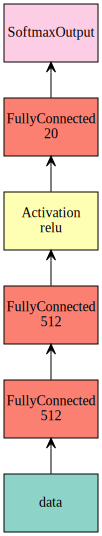

In [19]:
data = mx.symbol.Variable('data')
# data = mx.symbol.Dropout(data=data, p=0.2)
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=512)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2  = mx.symbol.FullyConnected(data = fc1, name = 'fc2', num_hidden = 512)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=20)
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

mx.viz.plot_network(mlp)

In [20]:
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

model = mx.model.FeedForward(
    ctx = mx.cpu(),       # Run on CPU
    symbol = mlp,         # Use the network we just defined
    num_epoch = 500,       # Train for 10 epochs
    learning_rate = 0.1,  # Learning rate
    momentum = 0.9,       # Momentum for SGD with momentum
    wd = 0.00001)         # Weight decay for regularization
model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter)#,  # Testing data set. MXNet computes scores on test set every epoch
    #batch_end_callback = mx.callback.Speedometer(batch_size, 2000))  # Logging module to print out progress

print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

INFO:root:Start training with [cpu(0)]


start: 2016-12-26 22:07:39


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.528
INFO:root:Epoch[0] Validation-accuracy=0.649529
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.487
INFO:root:Epoch[1] Validation-accuracy=0.651529
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.480
INFO:root:Epoch[2] Validation-accuracy=0.625647
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.471
INFO:root:Epoch[3] Validation-accuracy=0.631176
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=0.470
INFO:root:Epoch[4] Validation-accuracy=0.640824
INFO:root:Epoch[5] Resetting Data Iterator
INFO:root:Epoch[5] Time cost=0.484
INFO:root:Epoch[5] Validation-accuracy=0.633765
INFO:root:Epoch[6] Resetting Data Iterator
INFO:root:Epoch[6] Time cost=0.456
INFO:root:Epoch[6] Validation-accuracy=0.624824
INFO:root:Epoch[7] Resetting Data Iterator
INFO:root:Epoch[7] Time cost=0.475
INFO:root:Epoch[7] Validation-accuracy=0

start: 2016-12-26 22:08:47


In [21]:
predict_y_score_list = model.predict(test_x_list)
predict_y_list = np.argmax(predict_y_score_list, axis=1)

calc_score(test_y_list, predict_y_list)

Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30837772311357348, 0.29257962058176834, 0.2783388852250715, None)
weighted:  (0.54617629250030986, 0.5821727019498607, 0.54200581179134111, None)


In [ ]:
fc1_num_hidden_list = [128, 256, 512, 1024]
fc2_num_hidden_list = [128, 256, 512, 1024]
fc3_num_hidden_list = [5, 10, 20, 100]

for n1 in fc1_num_hidden_list:
    for n2 in fc2_num_hidden_list:
        for n3 in fc3_num_hidden_list:
            print '(3-layer-MLP) ', 'fc1_num_hidden:', n1, 'fc2_num_hidden:', n2, ';',  'fc3_num_hidden:', n3

            data = mx.symbol.Variable('data')
            # data = mx.symbol.Dropout(data=data, p=0.2)
            fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=n1)
            act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
            fc2  = mx.symbol.FullyConnected(data = fc1, name = 'fc2', num_hidden = n2)
            act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
            fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=n3)
            mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

            # mx.viz.plot_network(mlp)

            print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )
            model = mx.model.FeedForward(
                ctx = mx.cpu(),       # Run on CPU
                symbol = mlp,         # Use the network we just defined
                num_epoch = 500,       # Train for 10 epochs
                learning_rate = 0.1,  # Learning rate
                momentum = 0.9,       # Momentum for SGD with momentum
                wd = 0.00001)         # Weight decay for regularization
            model.fit(
                X=train_iter,  # Training data set
                eval_data=test_iter)#,  # Testing data set. MXNet computes scores on test set every epoch
                #batch_end_callback = mx.callback.Speedometer(batch_size, 2000))  # Logging module to print out progress
            print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

            predict_y_score_list = model.predict(test_x_list)
            predict_y_list = np.argmax(predict_y_score_list, axis=1)
            calc_score(test_y_list, predict_y_list)

            print '-----------------------'

### 上面的运行结果

```
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 128 ; fc3_num_hidden: 5
start: 2016-12-26 22:37:28
--
start: 2016-12-26 22:38:35
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30539396848199618, 0.31797882298194036, 0.30647026245781839, None)
weighted:  (0.55238169260127046, 0.54898873682935689, 0.54977448983367438, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 128 ; fc3_num_hidden: 10
start: 2016-12-26 22:38:35
--
start: 2016-12-26 22:39:42
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30086689794902605, 0.30759960988844492, 0.29952536919752087, None)
weighted:  (0.54993195596488265, 0.54777764321182032, 0.54801305657235155, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 128 ; fc3_num_hidden: 20
start: 2016-12-26 22:39:42
--
start: 2016-12-26 22:40:58
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30628388567015125, 0.31325829032458202, 0.30423130107422797, None)
weighted:  (0.54864282454502544, 0.55019983044689358, 0.54838548046214375, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 128 ; fc3_num_hidden: 100
start: 2016-12-26 22:40:58
--
start: 2016-12-26 22:42:54
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30950325637101506, 0.31507609570007894, 0.30852768820471915, None)
weighted:  (0.56150298120400555, 0.56449073513382586, 0.56215157059945364, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 256 ; fc3_num_hidden: 5
start: 2016-12-26 22:42:55
--
start: 2016-12-26 22:44:17
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31196387339435905, 0.30989581455415105, 0.30934014313417962, None)
weighted:  (0.5537857216433083, 0.56630737556013078, 0.5593181021002388, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 256 ; fc3_num_hidden: 10
start: 2016-12-26 22:44:17
--
start: 2016-12-26 22:45:40
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.29938661401317901, 0.3038501456772601, 0.29818864207971651, None)
weighted:  (0.54965885223550082, 0.55104759597916919, 0.54959689522718125, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 256 ; fc3_num_hidden: 20
start: 2016-12-26 22:45:40
--
start: 2016-12-26 22:47:07
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31243249259350858, 0.30635837986371128, 0.305232500445903, None)
weighted:  (0.55468448038572604, 0.57115175003027729, 0.56048899200673941, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 256 ; fc3_num_hidden: 100
start: 2016-12-26 22:47:07
--
start: 2016-12-26 22:49:20
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31078726022647218, 0.30930587077261423, 0.30683013200602482, None)
weighted:  (0.55574413444169091, 0.56400629768681121, 0.55871704155612079, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 512 ; fc3_num_hidden: 5
start: 2016-12-26 22:49:20
--
start: 2016-12-26 22:51:13
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31083833117308241, 0.31441699003696361, 0.30746516774256544, None)
weighted:  (0.55023173689232552, 0.559040813854911, 0.55322818525742956, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 512 ; fc3_num_hidden: 10
start: 2016-12-26 22:51:13
--
start: 2016-12-26 22:53:10
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.318139809437752, 0.31339557569045595, 0.31218221027725002, None)
weighted:  (0.5569414781345009, 0.57284728109482863, 0.56324673872578579, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 512 ; fc3_num_hidden: 20
start: 2016-12-26 22:53:10
--
start: 2016-12-26 22:55:14
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31661378684868008, 0.31492520476315461, 0.31159598443889608, None)
weighted:  (0.55474648764058665, 0.57139396875378468, 0.56135711269725153, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 512 ; fc3_num_hidden: 100
start: 2016-12-26 22:55:14
--
start: 2016-12-26 22:58:16
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.3142148192808577, 0.30999975502869309, 0.30935733223601669, None)
weighted:  (0.5541343757199424, 0.56751846917766746, 0.55969468271589928, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 1024 ; fc3_num_hidden: 5
start: 2016-12-26 22:58:16
--
start: 2016-12-26 23:01:16
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32682155122264728, 0.31678223318400789, 0.31811278903189855, None)
weighted:  (0.55755949499754942, 0.57853942109725087, 0.56566868932143977, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 1024 ; fc3_num_hidden: 10
start: 2016-12-26 23:01:16
--
start: 2016-12-26 23:03:58
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31967980808392055, 0.31853103421201029, 0.31528172783538683, None)
weighted:  (0.55562636722721792, 0.57187840620079933, 0.56208914576839308, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 1024 ; fc3_num_hidden: 20
start: 2016-12-26 23:03:58
--
start: 2016-12-26 23:06:44
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32301976904455065, 0.32100237043920077, 0.3187574840402696, None)
weighted:  (0.56128842234515086, 0.57369504662710424, 0.56612516226004195, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 128 fc2_num_hidden: 1024 ; fc3_num_hidden: 100
start: 2016-12-26 23:06:44
--
start: 2016-12-26 23:10:51
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31414690614203572, 0.30602905698277938, 0.30634486384008408, None)
weighted:  (0.55071517224801136, 0.56667070364539174, 0.55700838011674381, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 128 ; fc3_num_hidden: 5
start: 2016-12-26 23:10:51
--
start: 2016-12-26 23:12:08
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.3074727042319681, 0.31591859659169236, 0.30921159840819695, None)
weighted:  (0.5504137523538446, 0.54983650236163251, 0.54973318796959747, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 128 ; fc3_num_hidden: 10
start: 2016-12-26 23:12:08
--
start: 2016-12-26 23:13:27
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30188435187950446, 0.30613235397767691, 0.30056464564747176, None)
weighted:  (0.54729602685023337, 0.54499212789148599, 0.54551506907213354, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 128 ; fc3_num_hidden: 20
start: 2016-12-26 23:13:27
--
start: 2016-12-26 23:14:48
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30462134408155672, 0.31683452888703867, 0.30678069004954855, None)
weighted:  (0.5497316931527918, 0.54717209640305198, 0.5472174095139849, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 128 ; fc3_num_hidden: 100
start: 2016-12-26 23:14:48
--
start: 2016-12-26 23:16:46
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30563093602073016, 0.31210049228278802, 0.30508782752011976, None)
weighted:  (0.55328918516857839, 0.55492309555528641, 0.55319528803207862, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 256 ; fc3_num_hidden: 5
start: 2016-12-26 23:16:46
--
start: 2016-12-26 23:18:27
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30623215340473509, 0.31319511892249752, 0.30546456947752099, None)
weighted:  (0.54688212721618013, 0.56073634491946223, 0.5523639084249794, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 256 ; fc3_num_hidden: 10
start: 2016-12-26 23:18:27
--
start: 2016-12-26 23:20:08
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31045830248527351, 0.30676269707775361, 0.30523372427687151, None)
weighted:  (0.55320118921029537, 0.56727625045416008, 0.55907810453842666, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 256 ; fc3_num_hidden: 20
start: 2016-12-26 23:20:08
--
start: 2016-12-26 23:21:51
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32026695390467064, 0.32236039295935159, 0.317082022638284, None)
weighted:  (0.56188066225184163, 0.56667070364539174, 0.56318727806207125, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 256 ; fc3_num_hidden: 100
start: 2016-12-26 23:21:51
--
start: 2016-12-26 23:24:09
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31036822583047119, 0.31425366273910005, 0.30972897863325488, None)
weighted:  (0.55441756371857465, 0.56303742279278191, 0.55778809759024806, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 512 ; fc3_num_hidden: 5
start: 2016-12-26 23:24:09
--
start: 2016-12-26 23:26:32
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31277668423367827, 0.31658681461297355, 0.31130238375150404, None)
weighted:  (0.55678679460213742, 0.56231076662225987, 0.55850272616052143, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 512 ; fc3_num_hidden: 10
start: 2016-12-26 23:26:32
--
start: 2016-12-26 23:28:55
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31915235598728681, 0.31952974965168524, 0.31738837261058783, None)
weighted:  (0.55762295630485692, 0.56618626619837709, 0.56118743232808199, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 512 ; fc3_num_hidden: 20
start: 2016-12-26 23:28:55
--
start: 2016-12-26 23:31:28
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31579226164426255, 0.31140865776270854, 0.30885267042115216, None)
weighted:  (0.55466925879723239, 0.57357393726535066, 0.56150201318460413, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 512 ; fc3_num_hidden: 100
start: 2016-12-26 23:31:29
--
start: 2016-12-26 23:34:38
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30841491336411692, 0.30122676555184325, 0.30099078870106871, None)
weighted:  (0.54581581259345857, 0.56727625045416008, 0.55441073715703892, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 1024 ; fc3_num_hidden: 5
start: 2016-12-26 23:34:38
--
start: 2016-12-26 23:38:10
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32927524594258439, 0.32216793733821414, 0.32182504346410512, None)
weighted:  (0.56098760594415786, 0.57648056194743857, 0.5669074146244355, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 1024 ; fc3_num_hidden: 10
start: 2016-12-26 23:38:10
--
start: 2016-12-26 23:41:54
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31850592383794674, 0.31662052679080877, 0.31445581048960269, None)
weighted:  (0.5531743146930731, 0.56303742279278191, 0.55705883481928575, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 1024 ; fc3_num_hidden: 20
start: 2016-12-26 23:41:54
--
start: 2016-12-26 23:45:51
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31761344790763107, 0.31416543655313195, 0.3110397067468742, None)
weighted:  (0.552969782685091, 0.57357393726535066, 0.5610402334996849, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 256 fc2_num_hidden: 1024 ; fc3_num_hidden: 100
start: 2016-12-26 23:45:51
--
start: 2016-12-26 23:49:31
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32440633100159927, 0.31708363876054868, 0.31772403466369881, None)
weighted:  (0.5631432171221713, 0.5772072181179605, 0.56878844418392138, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 128 ; fc3_num_hidden: 5
start: 2016-12-26 23:49:32
--
start: 2016-12-26 23:51:36
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30793740335608377, 0.31236935344402705, 0.30635168496796578, None)
weighted:  (0.55691631663879648, 0.5499576117233862, 0.55263365836053224, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 128 ; fc3_num_hidden: 10
start: 2016-12-26 23:51:36
--
start: 2016-12-26 23:53:53
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30575666179172978, 0.30277918581462349, 0.30118196861920393, None)
weighted:  (0.55361349873898125, 0.56788179726292842, 0.55944683381182614, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 128 ; fc3_num_hidden: 20
start: 2016-12-26 23:53:53
--
start: 2016-12-26 23:56:12
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31336432122244384, 0.32268089872158673, 0.31368760285418273, None)
weighted:  (0.55232480608943912, 0.55746639215211335, 0.5539779262714819, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 128 ; fc3_num_hidden: 100
start: 2016-12-26 23:56:12
--
start: 2016-12-26 23:59:01
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31532383415855952, 0.32225481073974616, 0.31252878966511632, None)
weighted:  (0.55605700046234663, 0.56376407896330383, 0.55834038714848766, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 256 ; fc3_num_hidden: 5
start: 2016-12-26 23:59:01
--
start: 2016-12-27 00:01:43
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30905185991812278, 0.31140498119457816, 0.30786290031237684, None)
weighted:  (0.55495086830862206, 0.56037301683420127, 0.55699124808915168, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 256 ; fc3_num_hidden: 10
start: 2016-12-27 00:01:43
--
start: 2016-12-27 00:04:32
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32022912415626392, 0.3203206040180494, 0.31790379832093663, None)
weighted:  (0.5589915862778454, 0.56243187598401356, 0.55982365064833262, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 256 ; fc3_num_hidden: 20
start: 2016-12-27 00:04:32
--
start: 2016-12-27 00:07:33
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.3169620008200989, 0.31820556601681449, 0.31347948701002709, None)
weighted:  (0.55573533424982224, 0.57018287513624799, 0.56155951133082016, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 256 ; fc3_num_hidden: 100
start: 2016-12-27 00:07:33
--
start: 2016-12-27 00:11:07
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31243993509201601, 0.31624859764101332, 0.30897975799704958, None)
weighted:  (0.55282441431927676, 0.56521739130434778, 0.55710809539537609, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 512 ; fc3_num_hidden: 5
start: 2016-12-27 00:11:08
--
start: 2016-12-27 00:14:37
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31642903729435445, 0.30769791904698651, 0.30784830318928441, None)
weighted:  (0.5550116878201995, 0.5781760930119898, 0.56436406528622363, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 512 ; fc3_num_hidden: 10
start: 2016-12-27 00:14:37
--
start: 2016-12-27 00:18:02
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31779308656354954, 0.31900575659085029, 0.31454569283862094, None)
weighted:  (0.55175814693011471, 0.56763957853942115, 0.55813290803061733, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 512 ; fc3_num_hidden: 20
start: 2016-12-27 00:18:02
--
start: 2016-12-27 00:21:37
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32162435246294885, 0.32489093301217536, 0.31833197339071118, None)
weighted:  (0.56023831293145909, 0.56957732832747976, 0.56340763941449057, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 512 ; fc3_num_hidden: 100
start: 2016-12-27 00:21:37
--
start: 2016-12-27 00:26:41
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31418931878780793, 0.31486018916807756, 0.31107084626038028, None)
weighted:  (0.55669383425030816, 0.56327964151628918, 0.55906910243794328, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 1024 ; fc3_num_hidden: 5
start: 2016-12-27 00:26:41
--
start: 2016-12-27 00:33:09
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32773697191310236, 0.31718738552167808, 0.31742636954687409, None)
weighted:  (0.55926867390165236, 0.58786484195228295, 0.57069588682956507, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 1024 ; fc3_num_hidden: 10
start: 2016-12-27 00:33:09
--
start: 2016-12-27 00:39:43
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32123984658611304, 0.31098239753191437, 0.31113618606486704, None)
weighted:  (0.55876021428038125, 0.58374712365265835, 0.56858905242951796, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 1024 ; fc3_num_hidden: 20
start: 2016-12-27 00:39:43
--
start: 2016-12-27 00:46:28
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32288876734284844, 0.30573924924998369, 0.30923825639053354, None)
weighted:  (0.55560526860021386, 0.5821727019498607, 0.5660217601721812, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 512 fc2_num_hidden: 1024 ; fc3_num_hidden: 100
start: 2016-12-27 00:46:28
--
start: 2016-12-27 00:54:40
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.33054156246966038, 0.32179793329814199, 0.32145507747904994, None)
weighted:  (0.55865599172416858, 0.58084049897057044, 0.56747975628620473, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 128 ; fc3_num_hidden: 5
start: 2016-12-27 00:54:40
--
start: 2016-12-27 00:58:35
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30740280261833808, 0.31420079026436848, 0.3072006003740243, None)
weighted:  (0.55612111787261209, 0.55492309555528641, 0.55484232702799219, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 128 ; fc3_num_hidden: 10
start: 2016-12-27 00:58:35
--
start: 2016-12-27 01:03:02
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.29821066121100498, 0.30101639938986496, 0.29736796085809669, None)
weighted:  (0.54317752676755326, 0.55213758023495219, 0.54661855245136826, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 128 ; fc3_num_hidden: 20
start: 2016-12-27 01:03:02
--
start: 2016-12-27 01:07:36
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30957115256018186, 0.31951662621151344, 0.31112547051024353, None)
weighted:  (0.55506544523209533, 0.55383311129950341, 0.55375483677249349, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 128 ; fc3_num_hidden: 100
start: 2016-12-27 01:07:37
--
start: 2016-12-27 01:12:01
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.30714865820833603, 0.30722427136459535, 0.30340748024126729, None)
weighted:  (0.54884656842424417, 0.55649751725808405, 0.55165599042757929, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 256 ; fc3_num_hidden: 5
start: 2016-12-27 01:12:01
--
start: 2016-12-27 01:16:47
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31195069417216897, 0.30958193379720439, 0.3066648229296518, None)
weighted:  (0.55435991643027549, 0.5681240159864358, 0.55935652259140867, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 256 ; fc3_num_hidden: 10
start: 2016-12-27 01:16:47
--
start: 2016-12-27 01:21:00
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31579206407334165, 0.314877771150057, 0.31097293999305731, None)
weighted:  (0.55490429382129958, 0.57103064066852371, 0.56112482411215503, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 256 ; fc3_num_hidden: 20
start: 2016-12-27 01:21:00
--
start: 2016-12-27 01:26:12
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32729330022092906, 0.32673445681139823, 0.32129409244815765, None)
weighted:  (0.56173816665930143, 0.57648056194743857, 0.56714798130262789, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 256 ; fc3_num_hidden: 100
start: 2016-12-27 01:26:12
--
start: 2016-12-27 01:32:29
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32021494549765556, 0.31897561626772147, 0.31691896257787783, None)
weighted:  (0.56134091623613924, 0.56921400024221869, 0.56439504360391135, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 512 ; fc3_num_hidden: 5
start: 2016-12-27 01:32:29
--
start: 2016-12-27 01:40:25
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31487625523226576, 0.30774154667381681, 0.30754422871038151, None)
weighted:  (0.55482188103487373, 0.57103064066852371, 0.56127824456622355, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 512 ; fc3_num_hidden: 10
start: 2016-12-27 01:40:25
--
start: 2016-12-27 01:48:03
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31825234679312697, 0.30692295926793217, 0.30882308118368174, None)
weighted:  (0.5566202937363498, 0.57757054620322146, 0.56521102272471435, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 512 ; fc3_num_hidden: 20
start: 2016-12-27 01:48:04
--
start: 2016-12-27 01:55:05
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31653586850990312, 0.31321922354798665, 0.31041450861941433, None)
weighted:  (0.55514458320306725, 0.57296839045658232, 0.56196749699894666, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 512 ; fc3_num_hidden: 100
start: 2016-12-27 01:55:05
--
start: 2016-12-27 02:02:57
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32153070180543192, 0.31578355600483049, 0.31482312050948441, None)
weighted:  (0.55773979805431639, 0.57272617173307494, 0.56365892658299399, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 1024 ; fc3_num_hidden: 5
start: 2016-12-27 02:02:57
--
start: 2016-12-27 02:14:09
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32037636160398703, 0.3105542525213239, 0.31119282408786131, None)
weighted:  (0.55113907562513209, 0.5721206249243066, 0.5595091685613085, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 1024 ; fc3_num_hidden: 10
start: 2016-12-27 02:14:09
--
start: 2016-12-27 02:25:39
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31641342528207694, 0.30443989990958198, 0.30591370771442, None)
weighted:  (0.54982072704850005, 0.57587501513867023, 0.56029725175540213, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 1024 ; fc3_num_hidden: 20
start: 2016-12-27 02:25:40
--
start: 2016-12-27 02:37:25
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.32904438390366419, 0.31624978248586955, 0.31844955283735399, None)
weighted:  (0.56139279305155088, 0.58738040450526829, 0.57183931302924274, None)
-----------------------
(3-layer-MLP)  fc1_num_hidden: 1024 fc2_num_hidden: 1024 ; fc3_num_hidden: 100
start: 2016-12-27 02:37:25
start: 2016-12-27 02:51:33
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.31800905034849891, 0.31106899256463794, 0.31102598047887275, None)
weighted:  (0.55610164950342655, 0.57781276492672884, 0.56492860710357096, None)
-----------------------
```

In [ ]:
# SMOTE up-sampling training data
sm = SMOTE(kind='regular')
train_x_list_smote, train_y_list_smote = sm.fit_sample(train_x_list, train_y_list)
train_x_list_smote, train_y_list_smote = sm.fit_sample(train_x_list_smote, train_y_list_smote)
train_x_list_smote, train_y_list_smote = sm.fit_sample(train_x_list_smote, train_y_list_smote)
train_x_list_smote, train_y_list_smote = sm.fit_sample(train_x_list_smote, train_y_list_smote)
train_x_list_smote, train_y_list_smote = sm.fit_sample(train_x_list_smote, train_y_list_smote)

# split training data to 5 different classes
train_x_lists = [[] for i in range(5)]
for i in xrange(len(train_y_list_smote)):
    train_x_lists[int(train_y_list_smote[i])].append(train_x_list_smote[i])
for i in xrange(5):
    print 'number of class', i, ':', len(train_x_lists[i])

In [ ]:
fc1_num_hidden_list = [128, 256, 512, 1024]
fc2_num_hidden_list = [128, 256, 512, 1024]
fc3_num_hidden_list = [5, 10, 20, 100]

for n1 in fc1_num_hidden_list:
    for n2 in fc2_num_hidden_list:
        for n3 in fc3_num_hidden_list:
            print '(3-layer-MLP) ', 'fc1_num_hidden:', n1, 'fc2_num_hidden:', n2, ';',  'fc3_num_hidden:', n3

            data = mx.symbol.Variable('data')
            # data = mx.symbol.Dropout(data=data, p=0.2)
            fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=n1)
            act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
            fc2  = mx.symbol.FullyConnected(data = fc1, name = 'fc2', num_hidden = n2)
            act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
            fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=n3)
            mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

            # mx.viz.plot_network(mlp)

            print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )
            model = mx.model.FeedForward(
                ctx = mx.cpu(),       # Run on CPU
                symbol = mlp,         # Use the network we just defined
                num_epoch = 500,       # Train for 10 epochs
                learning_rate = 0.1,  # Learning rate
                momentum = 0.9,       # Momentum for SGD with momentum
                wd = 0.00001)         # Weight decay for regularization
            model.fit(
                X=train_iter,  # Training data set
                eval_data=test_iter)#,  # Testing data set. MXNet computes scores on test set every epoch
                #batch_end_callback = mx.callback.Speedometer(batch_size, 2000))  # Logging module to print out progress
            print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

            predict_y_score_list = model.predict(test_x_list)
            predict_y_list = np.argmax(predict_y_score_list, axis=1)
            calc_score(test_y_list, predict_y_list)

            print '-----------------------'

In [ ]:
print predict_y_list[:100]

In [ ]:
print test_y_list[:100]